In [12]:
import numpy as np
import pandas as pd
import polars as pl
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from lets_plot import *
LetsPlot.setup_html()

In [13]:
import os
from dotenv import load_dotenv
load_dotenv()

api_key = os.getenv("API_KEY")

import mosqlient

In [14]:
data = pl.read_parquet('../data/dataset_complete_dengue_uf.parquet')
data = data.rename({'casos': 'target'})
# data = data.to_pandas()

In [15]:
data

date,epiweek,week,month,year,uf,train_1,target_1,train_2,target_2,train_3,target_3,temp_min,temp_med,temp_max,precip_min,precip_med,precip_max,pressure_min,pressure_med,pressure_max,rel_humid_min,rel_humid_med,rel_humid_max,thermal_range,rainy_days,cope_forecast_temp_med_1,cope_forecast_temp_med_2,cope_forecast_temp_med_3,cope_forecast_temp_med_4,cope_forecast_temp_med_5,cope_forecast_temp_med_6,cope_forecast_umid_med_1,cope_forecast_umid_med_2,cope_forecast_umid_med_3,cope_forecast_umid_med_4,cope_forecast_umid_med_5,cope_forecast_umid_med_6,cope_forecast_precip_tot_1,cope_forecast_precip_tot_2,cope_forecast_precip_tot_3,cope_forecast_precip_tot_4,cope_forecast_precip_tot_5,cope_forecast_precip_tot_6,target,population,enso,iod,pdo,uf_latitude,uf_longitude
datetime[ms],i64,i64,i8,i64,str,bool,bool,bool,bool,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64
2025-01-12 00:00:00,202503,3,1,2025,"""TO""",false,false,false,false,false,true,22.138749,24.057032,26.84019,10.88733,60.174407,140.204768,0.962396,0.964428,0.966244,75.130896,88.733201,96.74699,4.701441,7.0,25.308988,25.830133,25.763737,25.900077,27.015837,27.563772,84.409679,80.433945,82.455884,77.892055,60.432103,44.026481,0.000122,0.000083,0.000091,0.00005,0.00001,0.000001,63,1646768,-0.617271,-1.846962,0.895957,-48.430602,-9.31975
2014-06-22 00:00:00,201426,26,6,2014,"""RS""",true,false,true,false,true,false,13.881409,15.605499,17.993226,11.72883,65.131862,156.096865,0.975752,0.977503,0.979033,85.879496,92.737578,96.795832,4.111817,6.371972,13.533832,13.559349,14.707543,16.104292,17.480135,19.731007,82.331036,81.845817,79.518881,77.887221,77.505355,78.17229,0.000064,0.00005,0.000048,0.000059,0.000066,0.000083,2,11204725,0.535552,-0.575136,0.759011,-53.831355,-30.416569
2022-07-17 00:00:00,202229,29,7,2022,"""RR""",false,false,true,false,true,false,22.988862,25.389397,28.503769,4.012438,25.081429,58.899772,0.98043,0.982933,0.984505,71.737148,86.339986,95.839343,5.514907,7.0,24.466519,25.154187,26.101475,26.756211,26.400514,26.048775,88.648374,86.673864,81.26934,77.408311,79.914646,77.921667,0.000088,0.000069,0.00004,0.000038,0.000048,0.000039,0,636303,null,null,null,-61.199741,1.845881
2010-09-05 00:00:00,201036,36,9,2010,"""AL""",true,false,true,false,true,false,19.897833,22.686755,25.932088,0.479674,4.242639,12.600348,0.983356,0.98508,0.98683,60.070054,75.605919,88.69418,6.034255,6.930401,23.564616,25.145064,26.109624,26.27451,26.241603,26.138405,73.268113,70.324931,67.518779,69.060938,71.187645,73.955792,0.000017,0.000012,0.000012,0.000018,0.000026,0.000033,498,3120922,null,null,null,-36.683792,-9.656848
2016-08-07 00:00:00,201632,32,8,2016,"""SC""",true,false,true,false,true,false,9.65177,13.252,17.66485,0.908495,18.382974,48.725876,0.962044,0.963907,0.965425,61.13328,80.328763,93.38765,8.01308,4.718849,14.914794,16.69275,18.095596,19.32707,21.193124,21.988447,80.918902,81.389251,81.067247,79.752328,80.020957,81.081046,0.000034,0.000061,0.000064,0.000059,0.000058,0.000074,4,6910553,0.187623,-1.365915,1.170794,-49.922974,-27.655432
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2013-09-22 00:00:00,201339,39,9,2013,"""PR""",true,false,true,false,true,false,11.615927,15.377604,19.988176,6.499592,33.435092,101.285525,0.925985,0.927816,0.929478,57.234344,74.827917,88.509653,8.372249,5.502345,19.408396,19.97483,21.149154,22.050524,22.624147,22.595278,69.098095,75.494875,77.554477,78.763251,80.754653,82.010391,0.000043,0.000065,0.000066,0.000073,0.000083,0.000078,27,10997465,null,null,null,-51.816309,-24.617297
2011-02-27 00:00:00,201109,9,2,2011,"""RJ""",true,false,true,false,true,false,22.060745,23.432975,25.618789,7.92393,40.822148,103.685465,0.974216,0.975333,0.976468,76.627702,87.463242,94.56354,3.558044,7.0,24.636216,23.132018,21.267695,19.725883,18.159558,18.016569,79.040073,83.761173,81.862735,80.2

In [16]:
exo = ['precip_min','precip_max','temp_min','temp_max','pressure_min','pressure_max','population']
train_1 = data.filter(pl.col('train_1'))[['uf','date','target',*exo]]
train_1 = TimeSeriesDataFrame.from_data_frame(train_1.to_pandas(),id_column='uf',timestamp_column='date')
test_1 =  data.filter(
    pl.col('target_1') | (
        # ~pl.col('train_1') & 
        (pl.col('date') < np.max(np.array(data.filter(pl.col('target_1')).sort('date')['date'])))
    )
)[['uf','date','target',*exo]]
test_1 = TimeSeriesDataFrame.from_data_frame(test_1.to_pandas(),id_column='uf',timestamp_column='date')

In [17]:
end_1 = np.array(data.filter(pl.col('train_1')).sort('date')['epiweek'])[-1]
end_2 = np.array(data.filter(pl.col('target_1')).sort('date')['epiweek'])[-1]

# prediction_length = (init_2 - end_1) + test_1.reset_index()[test_1.reset_index()['item_id'] == 'CE'].shape[0]
# prediction_length = end_2 - end_1
prediction_length = 68

In [18]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target="target",
).fit(
    train_data=train_1,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_small", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
            {"model_path": "bolt_small",
             "covariate_regressor": "CAT",
             "target_scaler": "standard",
             "fine_tune": True,
             "ag_args": {"name_suffix": "FineTuned-Covariates"}},
        ]
    },
    time_limit=60,  # time limit in seconds
    enable_ensemble=False,
    # presets='fast_training'
)

Beginning AutoGluon training... Time limit = 60s
AutoGluon will save models to '/Users/davibarreira/Documents/DSProjects/Mosqlimate/jbd-mosqlimate-sprint/notebooks/AutogluonModels/ag-20250715_212611'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.5.0: Tue Apr 22 19:54:33 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T8122
CPU Count:          8
GPU Count:          0
Memory Avail:       5.39 GB / 16.00 GB (33.7%)
Disk Space Avail:   430.79 GB / 926.35 GB (46.5%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'mode

In [19]:
predictor.leaderboard(test_1)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosFineTuned-Covariates[bolt_small],-0.539095,-0.675302,0.371602,0.284876,26.955148,3
1,ChronosFineTuned[bolt_small],-0.550172,-0.678729,0.737048,0.213521,23.622864,2
2,ChronosZeroShot[bolt_small],-0.602265,-0.670684,1.462366,1.870403,1.569015,1


In [30]:
predictions = predictor.predict(train_1,model='ChronosFineTuned[bolt_small]')
qs = [str(i) for i in np.sort([float(i) for i in predictions.columns[1:]])]
def check_monotonicity(row, qs):
    return np.all(np.diff(row[qs]) >= 0)

predictions['mono'] = predictions.apply(lambda r: check_monotonicity(r,qs),axis=1)

/var/folders/sz/kh2xcmy51n70hznv18vzsqxr0000gn/T/ipykernel_1699/973168253.py:1: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  ufs = pd.unique(data['uf'])
data with frequency 'IRREG' has been resampled to frequency 'W-SUN'.


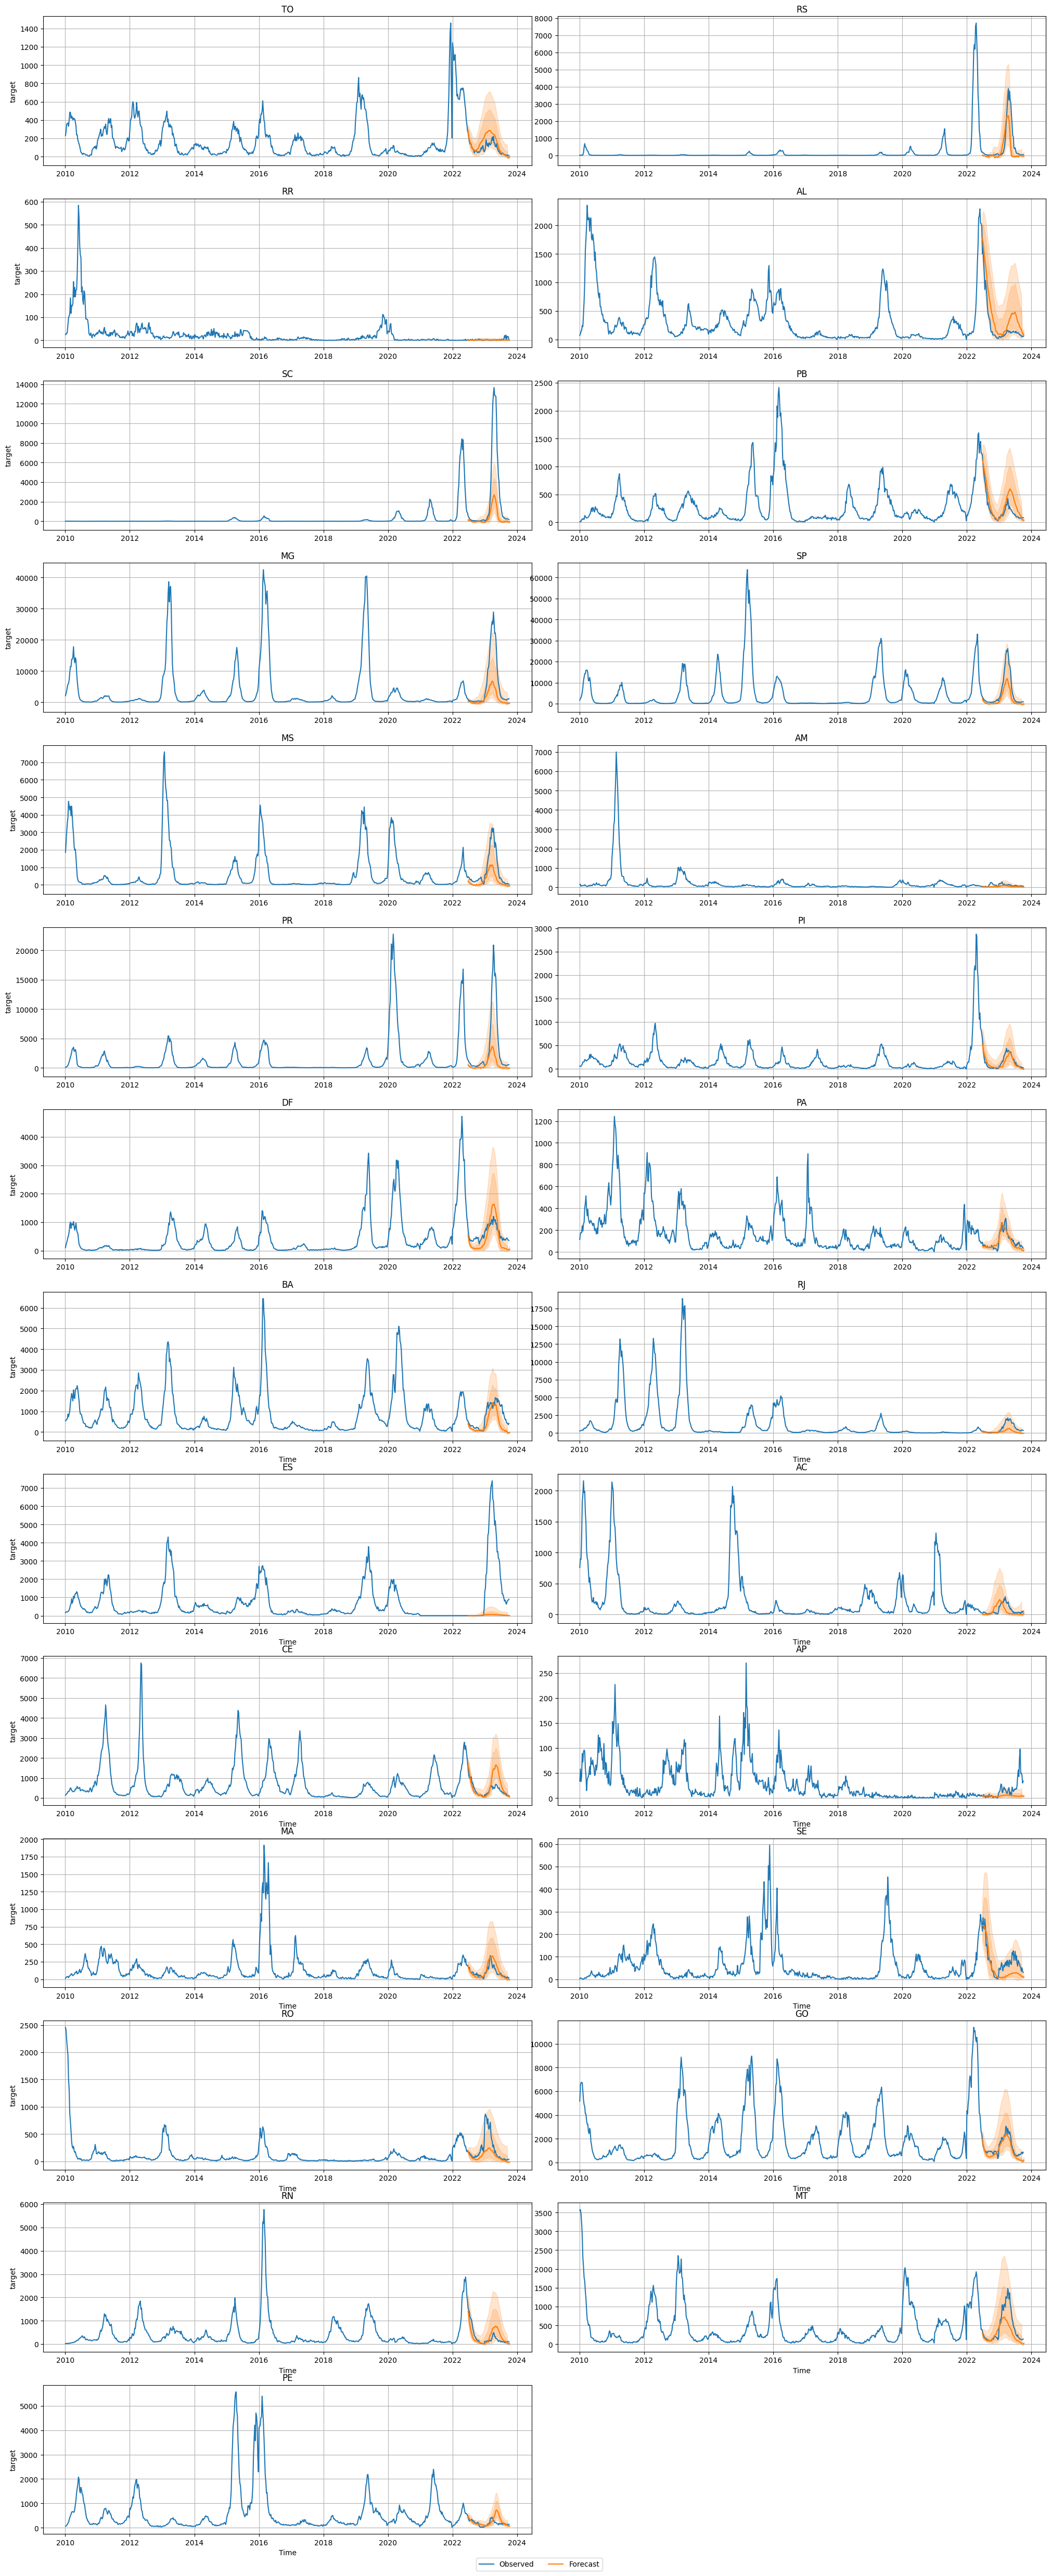

In [37]:
ufs = pd.unique(data['uf'])
predictor.plot(
    data=pd.concat([train_1,test_1]),
    quantile_levels=[0.1,0.2,0.5,0.8,0.9],
    predictions=predictions,
    item_ids = ufs,
    max_num_item_ids=None,
    max_history_length=1000,
)

In [22]:
intervals = [0.5,0.8,0.9,0.95]

quantiles = [[np.round(0.5 - i/2,decimals=3), np.round(0.5 + i/2,decimals=3)]for i in intervals]
quantiles

[[0.25, 0.75], [0.1, 0.9], [0.05, 0.95], [0.025, 0.975]]

In [23]:
def estimate_quantile(predictions,target_quantile):
    quantile_values = np.arange(0.1,1.0, 0.1)
    if target_quantile in quantile_values:
        return predictions[str(target_quantile)]
    if target_quantile < 0.1:
        return predictions['0.1'] - (0.1 - target_quantile)*(predictions['0.2'] - predictions['0.1'])/0.1
    if target_quantile > 0.9:
        return predictions['0.9'] + (target_quantile - 0.9)*(predictions['0.9'] - predictions['0.8'])/0.1

    lower_bound = np.round(max(q for q in quantile_values if q < target_quantile),decimals=2)
    upper_bound = np.round(min(q for q in quantile_values if q > target_quantile),decimals=2)
    lower_values = predictions[str(lower_bound)]
    upper_values = predictions[str(upper_bound)]
    slope = (upper_values - lower_values) / (upper_bound - lower_bound)
    return lower_values + slope * (target_quantile - lower_bound)

for q in np.hstack(quantiles):
    predictions[str(q)] = predictions.apply(lambda row: estimate_quantile(row, target_quantile=q), axis=1)

In [40]:
predictions[~predictions['mono']]
# predictions

mean        0.1        0.2        0.3        0.4  \
item_id timestamp                                                           
RS      2022-07-03 -13.274155 -40.921127 -25.438004 -23.127869 -12.913925   
        2022-07-10  -5.136078 -35.630585 -17.020645  -8.673370  -7.499329   
        2022-07-17 -18.212601 -54.115326 -32.447586 -30.415802 -22.243042   
        2022-07-24 -15.630600 -55.688629 -38.514954 -29.288483 -27.132675   
        2022-07-31 -45.714386 -86.415024 -80.278687 -66.393265 -60.916763   
...                       ...        ...        ...        ...        ...   
PI      2023-01-29  45.708664  27.044403  22.429825  24.623108  30.888290   
        2023-09-03  20.024353   5.725739  13.344742  16.336121  20.734558   
        2023-09-10   9.239624  -2.075073   2.631439   7.803589  11.100311   
RN      2022-12-11  12.759857  -9.593658 -11.339020  -7.241638  -0.827118   
        2022-12-18  -2.669556 -26.289948 -28.314575 -22.460083 -16.700470   

                          0.5        0.6         0.7         0.8         0.9  \
item_id timestamp                                                              
RS      2022-07-03 -13.274155  -5.405930    3.478958   18.022163   79.034401   
        2022-07-10  -5.136078   6.545273    0.642181    7.374008   59.300301   
        2022-07-17 -18.212601 -15.607422  -10.900650  -13.648407   10.414154   
        2022-07-24 -15.630600 -13.643066   -1.256622   -7.373184   13.358170   
        2022-07-31 -45.714386 -37.640823  -37.764847  -48.699020  -10.690430   
...                       ...        ...         ...         ...         ...   
PI      2023-01-29  45.708664  67.697937  105.220612  183.838898  372.920349   
        2023-09-03  20.024353  23.475784   32.464523   58.345322  148.449707   
        2023-09-10   9.239624  12.769608   21.433807   46.527832  134.167465   
RN      2022-12-11  12.759857  33.431549   68.826569  172.344727  500.797058   
        2022-12-18  -2.669556  27.548828   69.940155  190.714844  560.547180   

                     mono  
item_id timestamp          
RS      2022-07-03  False  
        2022-07-10  False  
        2022-07-17  False  
        2022-07-24  False  
        2022-07-31  False  
...                   ...  
PI      2023-01-29  False  
        2023-09-03  False  
        2023-09-10  False  
RN      2022-12-11  False  
        2022-12-18  False  

[200 rows x 11 columns]

In [33]:
pred = predictions.drop(columns=['mono','mean'])
i = 2
sample = pl.DataFrame(
    {'q':pred.iloc[i].index.values.astype(float),

    'y':pred.iloc[i].values,}
)

(
    ggplot(data=sample)
    + geom_line(aes(x='q', y='y'), color='blue')
    + geom_point(aes(x='q', y='y'), color='blue')
)